Code for project 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

$\mathcal{IRENE'S \quad BLOCKS}$

Plot of the variables: High, Low, Close

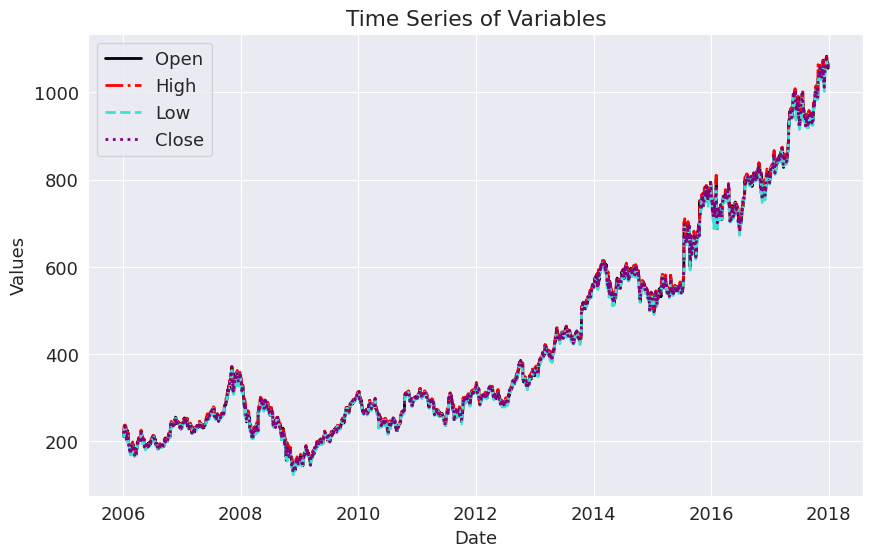

In [14]:
data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=['Date']) 
data.set_index('Date', inplace=True)
Open=data['Open']
High=data['High']
Low=data['Low']
Close=data['Close']
Volume=data['Volume']
plt.figure(figsize=(10, 6))
plt.plot(data.index, Open, label='Open', linewidth=2, linestyle='-', color='black' )
plt.plot(data.index, High, label='High', linewidth=2, linestyle='-.', color='red' )
plt.plot(data.index, Low, label='Low', linewidth=2, linestyle='--', color='turquoise' )
plt.plot(data.index, Close, label='Close', linewidth=2,linestyle=':', color='purple' )
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series of Variables')
plt.legend()
plt.grid(True)
plt.show()




Plot mean and SD envelopes to see better

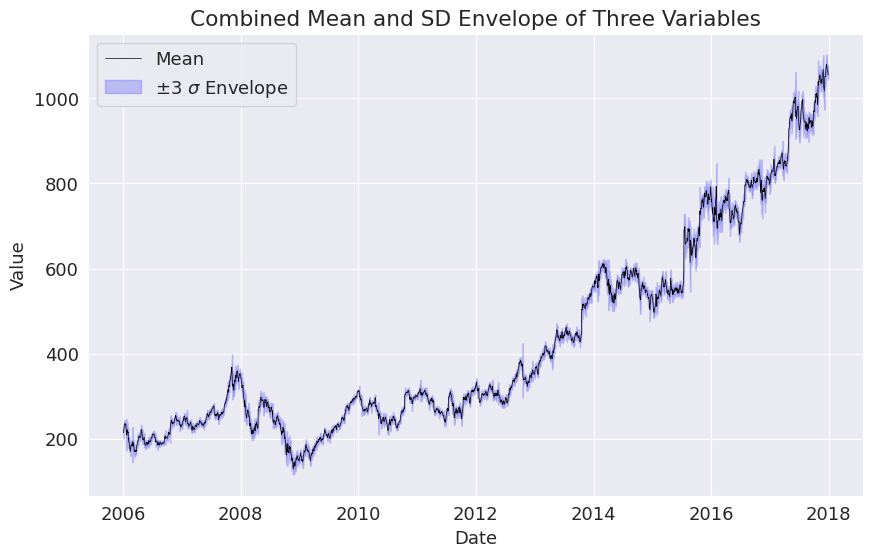

In [17]:
mean_all = data.iloc[:, [0,1, 2, 3]].mean(axis=1)
std_dev_all = data.iloc[:, [0,1, 2, 3]].std(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(data.index, mean_all, label='Mean', color='black', linewidth=0.5)
plt.fill_between(
    data.index,
    mean_all - 3*std_dev_all,  
    mean_all + 3*std_dev_all,  
    color='blue',
    alpha=0.2,  # Adjust transparency
    label='±3 $\sigma$ Envelope'
)

# Labeling the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Combined Mean and SD Envelope of Three Variables')
plt.legend()
plt.show()


Plot of the variable Volume

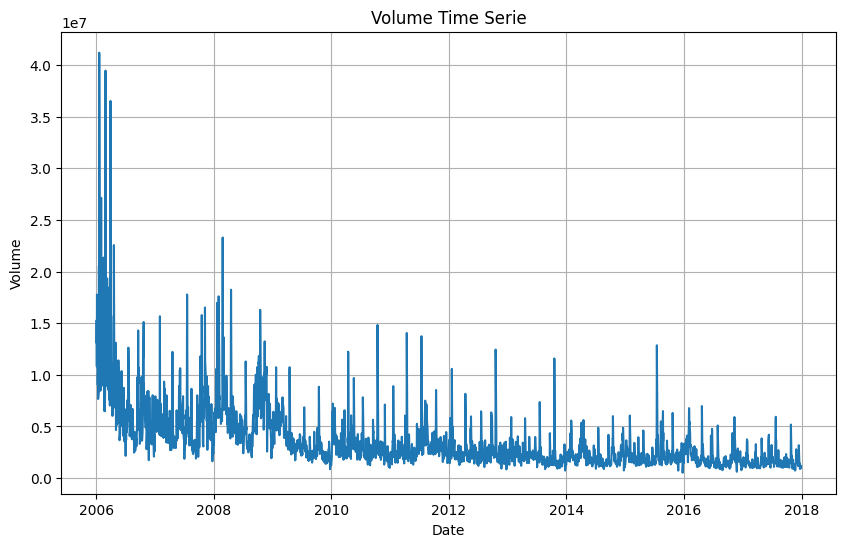

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, Volume, label="Volume")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume Time Serie')
plt.grid(True)
plt.show()

Seasonal Trent decomposition using LOESS (STL)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")


In [20]:
Open_ts = pd.Series(
    Open, index=pd.date_range("2006-01-03", periods=len(Open), freq="M"), name="Open"
)
Open_ts.describe()

/tmp/ipykernel_14315/3109631639.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  Open, index=pd.date_range("2006-01-03", periods=len(Open), freq="M"), name="Open"


count     102.000000
mean      432.528431
std       240.126381
min       152.250000
25%       250.320000
50%       311.150000
75%       586.635000
max      1039.940000
Name: Open, dtype: float64

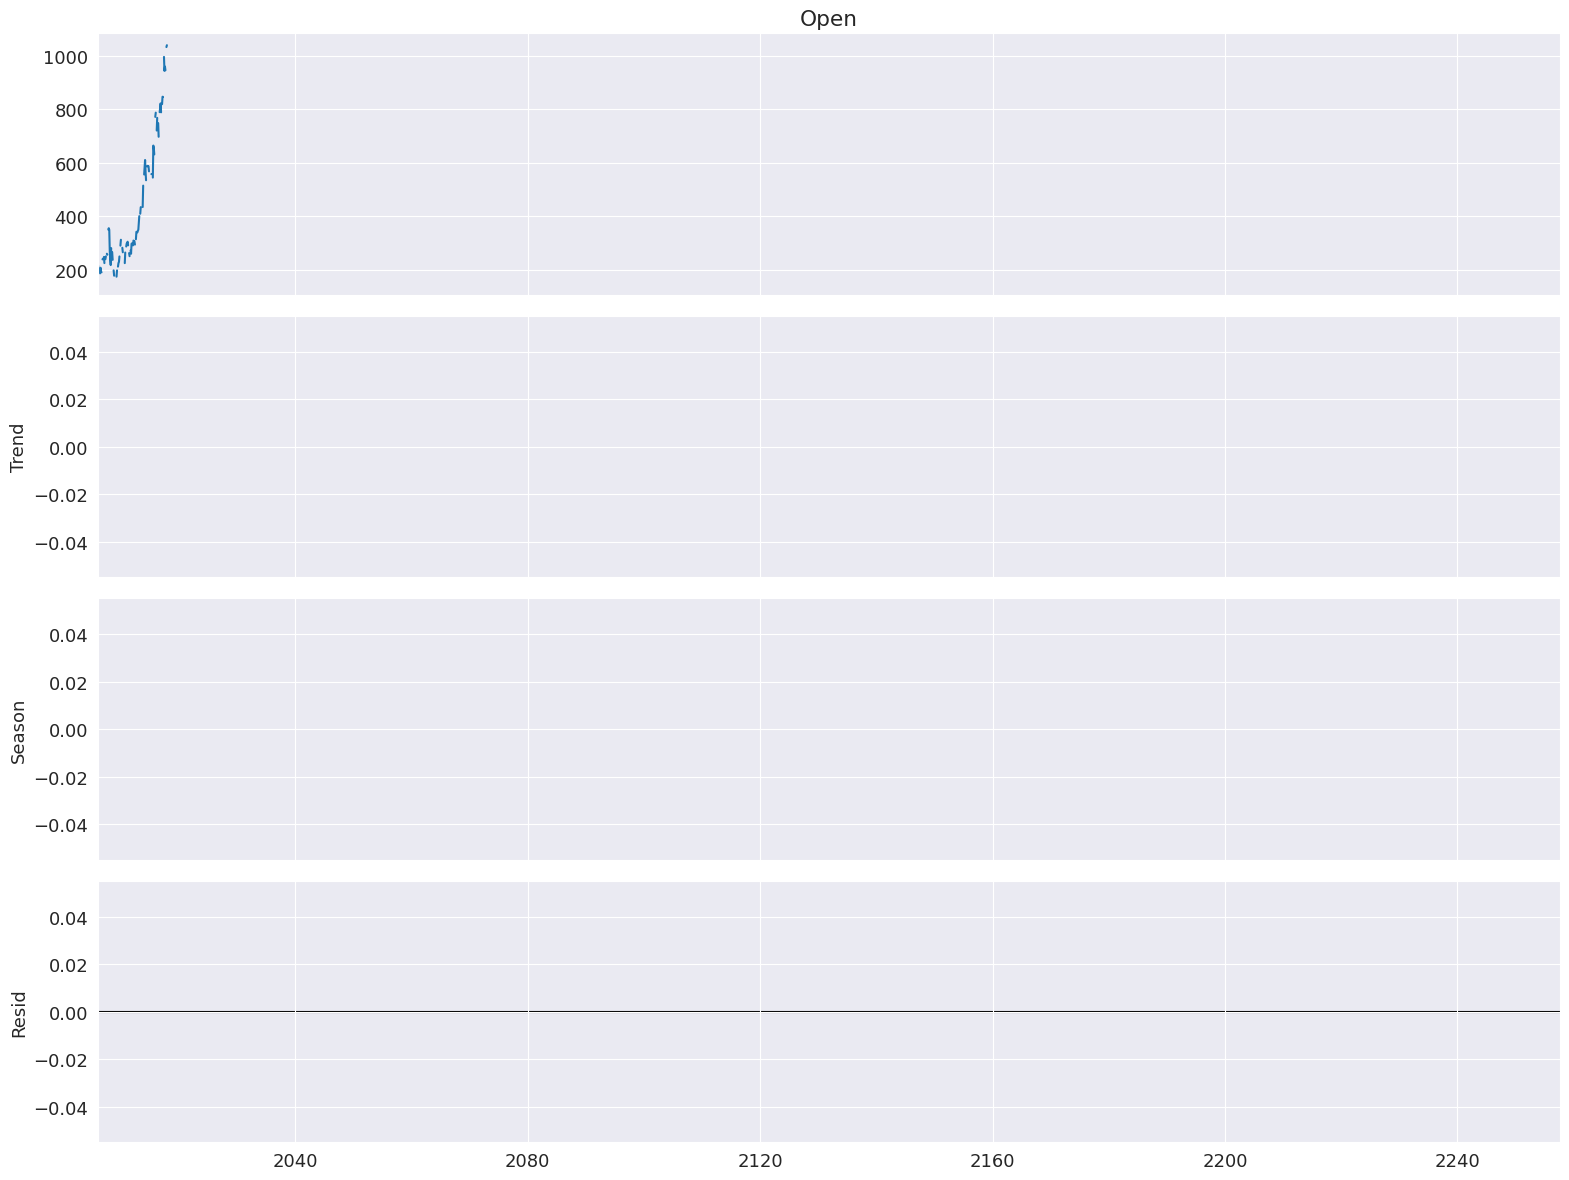

In [ ]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)
from statsmodels.tsa.seasonal import STL

stl = STL(Open_ts, seasonal=7, period=) # what to put as seasonal?
res = stl.fit()
fig = res.plot()


In [ ]:
# ANTON's BLOCK